In [95]:
#CODE TO PRODUCE REPLICAS OF JAME'S CHARTS
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

In [55]:
#STEP ONE: read and clean the three sets of data (CBO21, CBO24, and OMB's outlays), reshape to long format, and concatenate them

#CBO24
years = [i for i in range(2024, 2024+11)] 
cbo_24 = pd.read_excel('../data/cbo-2024-02-Spending-Projections.xlsx', header=7, sheet_name=1)
cbo_24 = cbo_24[[col for col in cbo_24.columns if col not in years]] #remove the BA cols
cbo_24.columns = cbo_24.columns.str.replace('.1', '') #clean the OT cols
cbo_24 = cbo_24.drop(columns=['Unnamed: 9', "Unnamed: 21", "Off-Budget?"]).drop(index=0).drop(cbo_24.index[-2:]) #drop the weird empty rows and the empty cols and offbud col
cbo_24["Agency"] = cbo_24["Agency"].str.strip()
years = [str(i) for i in years]
cbo_24_agencies = cbo_24[['Agency'] + years].groupby("Agency").sum().reset_index() #get sum of ots by agency
cbo_24_agencies['source'] = 'CBO24'
cbo_24_agencies[[str(year) for year in range(2018,2024)]] = np.nan #to make the concat work

#CBO21 
cbo_21 = pd.read_excel('../data/cbo-2021-02-11-spendingprojections.xlsx', header=7, sheet_name=1)
years_21 = [i for i in range(2021, 2032)]
cbo_21 = cbo_21[[col for col in cbo_21.columns if col not in years_21]].drop(columns=["Off-Budget?", "Unnamed: 9", "Unnamed: 21"]) #remove the BA cols, unnamed and unnecessary columns
cbo_21.columns = cbo_21.columns.str.replace('.1', '') #clean OT columns
cbo_21["Agency"] = cbo_21["Agency"].str.strip()
cbo_21['Agency'] = cbo_21['Agency'].replace('Other Defense Civil Programs', 'Other Defense--Civil Programs').replace("Committee for Purchase from People Who Are Blind or Severely Dis", "Committee for Purchase From People Who Are Blind/Disabled" )
years_21 = [str(i) for i in years_21]
cbo_21_agencies = cbo_21[["Agency"] + years_21].groupby("Agency").sum().reset_index() #group by agency and sum the total
cbo_21_agencies["source"] = "CBO21"
cbo_21_agencies[["2018", "2019", "2020", "2032", "2033", "2034"]] = np.nan #to make the concat work

#actual outlays (OMB)
omb = pd.read_excel('../data/omb_ots_data.xlsx', header=2, sheet_name="Table")
actual_yrs = [str(i) for i in range(2018, 2024)]
omb = omb[["Department or other unit"] + actual_yrs]
omb.rename(columns={"Department or other unit": "Agency"}, inplace=True)
omb['source'] = 'OMB'
omb[[str(year) for year in range(2024, 2035)]] = np.nan #to make the concat work

#Reshape each dataframe to long format
cbo21_long = cbo_21_agencies.melt(id_vars=['Agency', 'source'], var_name='year', value_name='outlays')
cbo24_long = cbo_24_agencies.melt(id_vars=['Agency', 'source'], var_name='year', value_name='outlays')
omb_long = omb.melt(id_vars=['Agency', 'source'], var_name='year', value_name='outlays')

#Concatenate the reshaped dataframes
df_long = pd.concat([cbo24_long, cbo21_long, omb_long], ignore_index=True).rename(columns={"Agency": "agency"})
#filter the data to only include the agencies in the CBO24 data
df_long = df_long[df_long['agency'].isin(cbo_24_agencies['Agency'])]
# Get the 'outlays' values from 'OMB' for 2020 and 2022
omb_2020_outlays = df_long.loc[(df_long['source'] == 'OMB') & (df_long['year'] == '2020'), ['agency', 'outlays']].set_index('agency')
omb_2023_outlays = df_long.loc[(df_long['source'] == 'OMB') & (df_long['year'] == '2023'), ['agency', 'outlays']].set_index('agency')
# Replace the 'outlays' values in 'CBO21' for 2020 and 'CBO24' for 2022 with the values from 'OMB'
df_long.loc[(df_long['source'] == 'CBO21') & (df_long['year'] == '2020'), 'outlays'] = df_long.loc[(df_long['source'] == 'CBO21') & (df_long['year'] == '2020'), 'agency'].map(omb_2020_outlays['outlays'])
df_long.loc[(df_long['source'] == 'CBO24') & (df_long['year'] == '2023'), 'outlays'] = df_long.loc[(df_long['source'] == 'CBO24') & (df_long['year'] == '2023'), 'agency'].map(omb_2023_outlays['outlays'])

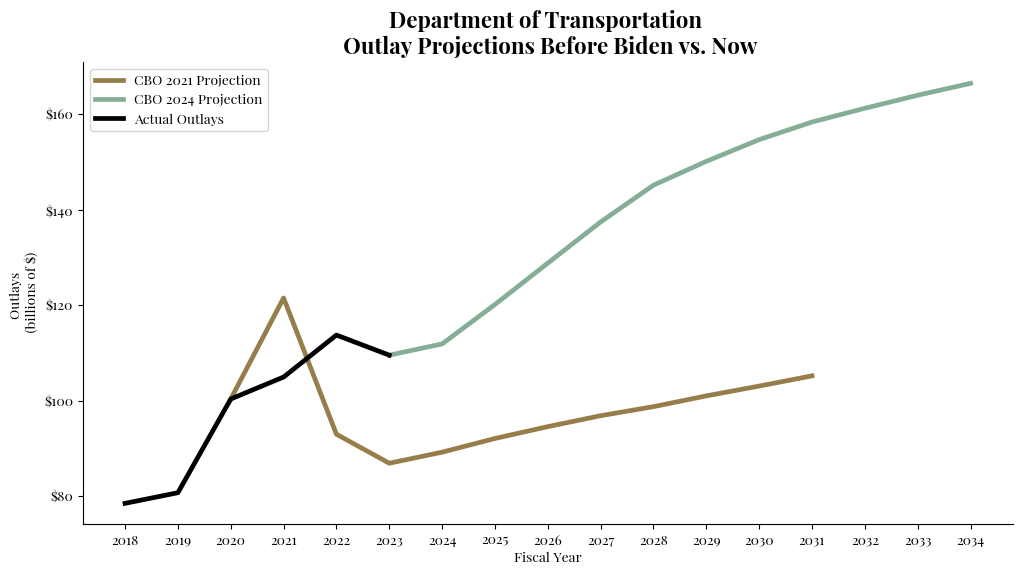

In [76]:
#STEP TWO: create the chart
agency = 'Department of Transportation'
df_agency = df_long[df_long['agency'] == agency]
df_agency = df_agency.sort_values(by=['source','year'])
df_agency['outlays'] = df_agency['outlays'] / 1000 #convert to billions

plt.rcParams['font.family'] = 'Playfair Display'
plt.figure(figsize=(12, 6))
palette = {'CBO21': '#967D4A', 'CBO24': '#84AE95', 'OMB': '#000000'}
lineplot = sns.lineplot(data=df_agency, x='year', y='outlays', hue='source', palette=palette, linewidth=3.4)
plt.title(f'{agency} \n Outlay Projections Before Biden vs. Now', weight='bold', fontsize=16)
plt.ylabel('Outlays \n (billions of $)')
plt.xlabel('Fiscal Year')
# Get the current legend
legend = lineplot.get_legend()
# Remove the legend title
legend.set_title('')
# Rename the legend labels
for t, l in zip(legend.texts, ('CBO 2021 Projection', 'CBO 2024 Projection', 'Actual Outlays')):
    t.set_text(l)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x:.0f}'))
sns.despine()
plt.show()


In [99]:
def linechart_maker(agency):
    df_agency = df_long[df_long['agency'] == agency]
    df_agency = df_agency.sort_values(by=['source','year'])
    df_agency['outlays'] = df_agency['outlays'] / 1000 #convert to billions
    sns.set_style('whitegrid')
    plt.rcParams['font.family'] = 'Playfair Display'
    plt.figure(figsize=(12, 6))
    palette = {'CBO21': '#967D4A', 'CBO24': '#84AE95', 'OMB': '#000000'}
    lineplot = sns.lineplot(data=df_agency, x='year', y='outlays', hue='source', palette=palette, linewidth=3.4)
    plt.title(f'{agency} \n Outlay Projections Before Biden vs. Now', weight='bold', fontsize=16)
    plt.ylabel('Outlays \n (billions of $)')
    plt.xlabel('Fiscal Year')
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
    lineplot.grid(False, 'both', 'x')
    legend = lineplot.get_legend() # Get the current legend
    legend.set_title('') # Remove the legend title
    for t, l in zip(legend.texts, ('CBO 2021 Projection', 'CBO 2024 Projection', 'Actual Outlays')): # Rename the legend labels
        t.set_text(l)
    
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x:.0f}'))
    sns.despine(offset=15, left=True)
    plt.show()

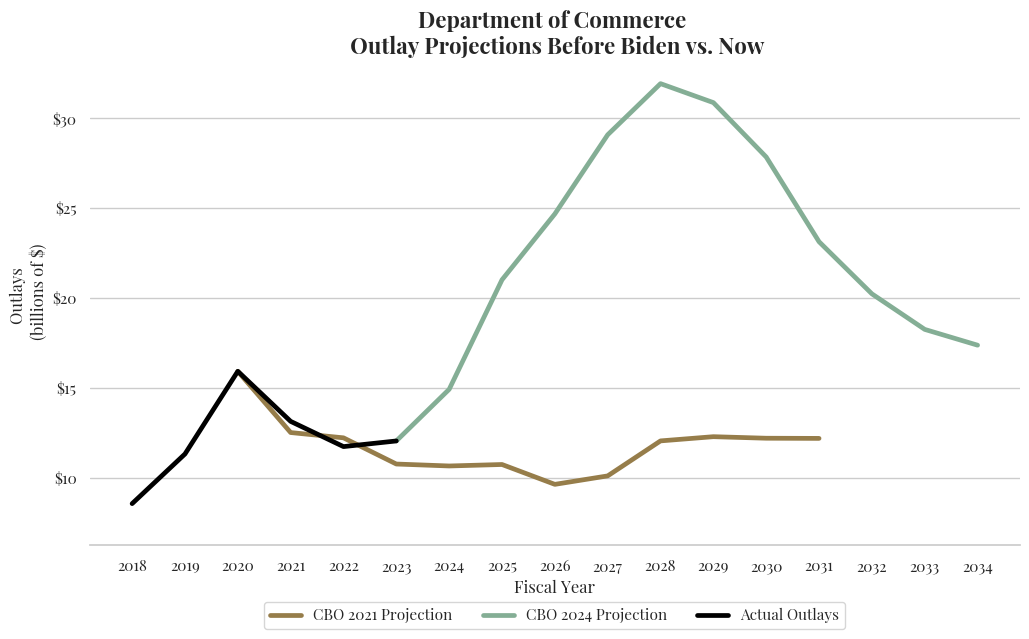

In [104]:
linechart_maker('Department of Commerce')